In [5]:
import pandas as pd
import numpy as np
import numpy.polynomial.polynomial as P
from scipy import stats

import textwrap

import warnings
warnings.filterwarnings( "ignore")
from matplotlib import pyplot as plt
%matplotlib inline

import walnut_utils as wnut
from importlib import reload

In [95]:
src = '../hpcc/traditional/'
dst = '../hpcc/traditional/results/'

fs = 15
marker = ['o', 'v','*','^', 's', '<', 'X', '>', 'p', '8', 'h', 'H', 'D', 'd', 'P']
#col_wong = ['#e69f00', '#009e73', '#0072b2', '#d55e00', '#cc79a7', '#f0e442', '#56b4e9']
col_wong = ['#d81b60', '#1e88e5', '#ffc107', '#004d40', '#56e495']
col_wong += col_wong

cattraitnames = ['EaseOfRemoval',
                 'ShellStrength',
                 'ShellTexture',
                 'ShellIntegrity',
                 'ShellColor',
                 'SEAL',
                 'PackingTissue',
                 'KernelFill',
                 'Plumpness']

col_labels =['Batch Name', 'Scan Name',
             'Nut Length','Nut Height', 'Nut Width',
             'Nut Volume',
             'Nut VA3D',
             'Nut Feret Ratio',
             'Nut Inverse Feret Ratio',
             'Nut Surface Area',
             'Nut Sphericity',
             'Nut Convex Surface Area',
             'Nut Convex Volume',
             'Nut Convex Area Ratio',
             'Nut Convex Volume Ratio',
             'Nut Convex Area Inverse Ratio',
             'Nut Convex Volume Inverse Ratio',
             'Krumbein Index',
             'Corey Index',
             'Sneed Index',
             'Janke Index',
             'Wadell Index',
             'Air Volume', 'Kernel Volume', 'Shell Volume', 'Packing Volume',
             'Air Volume Ratio', 'Kernel Volume Ratio', 'Shell Volume Ratio', 'Packing Volume Ratio',
             'Shell Rugosity',
             'Shell Thickness','Shell Thickness2','Shell Thickness3','Shell Thickness4',
             'External Shell Ratio', 'Bulge Shell Ratio', 'Protruding Shell Ratio',
             'External Shell Volume', 'Bulge Shell Volume', 'Protruding Shell Volume',
             'Kernel Length', 'Kernel Height', 'Kernel Width',
             'Kernel Surface Area',
             'Kernel Convex Volume',
             'Kernel Convex Surface Area',
             'Kernel Convex Area Ratio',
             'Kernel Convex Area Inverse Ratio',
             'Kernel Convex Volume Ratio',
             'Kernel Convex Volume Inverse Ratio']

col_units = ['', '',
             ' [mm]',' [mm]', ' [mm]',
             ' [mm$^3$]',
             '',
             '',
             '',
             ' [mm$^2$]',
             '',
             ' [mm$^2$]',
             ' [mm$^3$]',
             '',
             '',
             '',
             '',
             '',
             '',
             '',
             '',
             '',
             ' [mm$^3$]', ' [mm$^3$]', ' [mm$^3$]', ' [mm$^3$]',
             '', '', '', '',
             '',
             ' [mm]',' [mm]',' [mm]',' [mm]',
             '', '', '',
             ' [mm$^3$]', ' [mm$^3$]', ' [mm$^3$]',
             ' [mm]', ' [mm]', ' [mm]',
             ' [mm$^2$]',
             ' [mm$^3$]',
             ' [mm$^2$]',
             '',
             '',
             '',
             '']
scol_labels = np.asarray(col_labels, dtype=str)
filename = src + 'traditional_phenotypes_merged.csv'
df = pd.read_csv(filename, dtype={1:str})
print(df.shape)
df.head()

(1264, 66)


,bname,wname,nut_length,nut_height,nut_width,nut_vol,nut_va3d,nut_ratio_feret,nut_inv_ratio_feret,nut_area,...,ShellThickness,PackingTissue,KernelFill,%TipShrivel,%MinorShrivel,%MajorShrivel,Plumpness,EaseOfRemoval,PercentKernel,%Blank
0,2008SB_R4_T13,001,41.750477,33.582913,31.395051,20387.149371,4.941865,1.329843,0.751969,6147.314265,...,1.5,6.0,5.0,0.0,0.0,0.0,4.0,6.0,48.389312,0.0
1,2008SB_R4_T13,002,39.720443,33.450554,31.454860,20512.900734,4.643222,1.262776,0.791906,6045.635968,...,1.5,6.0,5.0,0.0,0.0,0.0,4.0,6.0,48.389312,0.0
2,2008SB_R4_T13,003,42.790987,35.768852,33.257804,24394.576769,4.596968,1.286645,0.777215,6763.478980,...,1.5,6.0,5.0,0.0,0.0,0.0,4.0,6.0,48.389312,0.0
3,2008SB_R4_T13,004,39.589858,34.400643,31.931823,21020.676969,4.496373,1.239825,0.806566,6079.521052,...,1.5,6.0,5.0,0.0,0.0,0.0,4.0,6.0,48.389312,0.0
4,2008SB_R4_T13,005,38.284326,34.049830,31.365337,19995.849647,4.335537,1.220594,0.819274,5809.316020,...,1.5,6.0,5.0,0.0,0.0,0.0,4.0,6.0,48.389312,0.0


# ANOVA

In [9]:
df.iloc[:,2:51].columns

Index(['nut_length', 'nut_height', 'nut_width', 'nut_vol', 'nut_va3d',
       'nut_ratio_feret', 'nut_inv_ratio_feret', 'nut_area', 'nut_sphericity',
       'nut_cnvx_area', 'nut_cnvx_vol', 'nut_ratio_cnvx_area',
       'nut_ratio_cnvx_vol', 'nut_inv_ratio_cnvx_area',
       'nut_inv_ratio_cnvx_vol', 'krumbein', 'corey', 'sneed', 'janke',
       'wadell', 'air_vol', 'meat_vol', 'shell_vol', 'vein_vol',
       'air_ratio_vol', 'meat_ratio_vol', 'shell_ratio_vol', 'vein_ratio_vol',
       'shell_rugosity', 'shell_thickness1', 'shell_thickness2',
       'shell_thickness3', 'shell_thickness4', 'shell_ext_ratio',
       'shell_thick_ratio', 'shell_prot_ratio', 'shell_ext_vol',
       'shell_thick_vol', 'shell_prot_vol', 'meat_length', 'meat_height',
       'meat_width', 'meat_area', 'meat_cnvx_vol', 'meat_cnvx_area',
       'meat_ratio_cnvx_area', 'meat_inv_ratio_cnvx_area',
       'meat_ratio_cnvx_vol', 'meat_inv_ratio_cnvx_vol'],
      dtype='object')

In [22]:
def correct_zero(arr):
    minval = np.min(arr[np.nonzero(arr[:,1])[0], 1])
    arr[arr[:,1] == 0, 1] = minval
    return arr

In [33]:
reload(wnut)
ss = np.s_[:,2:51]

F_onewayF= np.zeros((df.iloc[ss].shape[1], len(cattraitnames)))
KruskalH = np.zeros_like(F_onewayF)
F_onewayp= np.ones_like(F_onewayF)
Kruskalp = np.copy(F_onewayp)

for i in range(len(cattraitnames)):
    f_oneway, kruskal = wnut.anova(df, ss, cattraitnames[i])
    f_oneway = correct_zero(f_oneway)
    kruskal = correct_zero(kruskal)
    
    F_onewayF[:,i] = f_oneway[:,0]
    F_onewayp[:,i] = f_oneway[:,1]
    KruskalH[:,i]  = kruskal[:,0]
    Kruskalp[:,i] = kruskal[:,1]

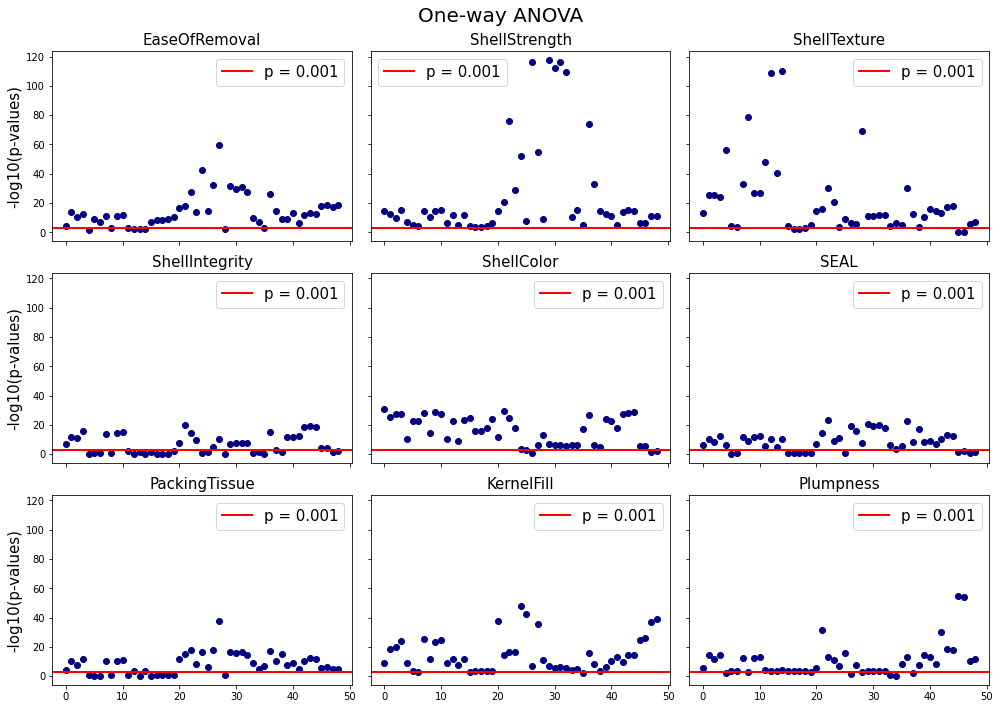

In [37]:
fig, ax = plt.subplots(3,3, figsize=(14,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
xvals = range(len(f_oneway))
fs = 15

for i in range(len(ax)):
    ax[i].scatter(xvals, -np.log10(F_onewayp[:,i]), c='navy')
    ax[i].axhline(y=-np.log10(0.05/50), c='red', lw=2, label='p = 0.001');
    ax[i].legend(fontsize=fs)
    ax[i].set_title(cattraitnames[i], fontsize=fs)

for i in [0,3,6]:
    ax[i].set_ylabel('-log10(p-values)', fontsize=fs);

fig.suptitle('One-way ANOVA', fontsize=20)
plt.tight_layout()

#filename = dst + 'ECT_ANOVA.jpg'
#plt.savefig(filename, bbox_inches='tight', dpi=100, format='jpg', pil_kwargs={'optimize':True})

../hpcc/traditional/results/KrukalWallis_traditional


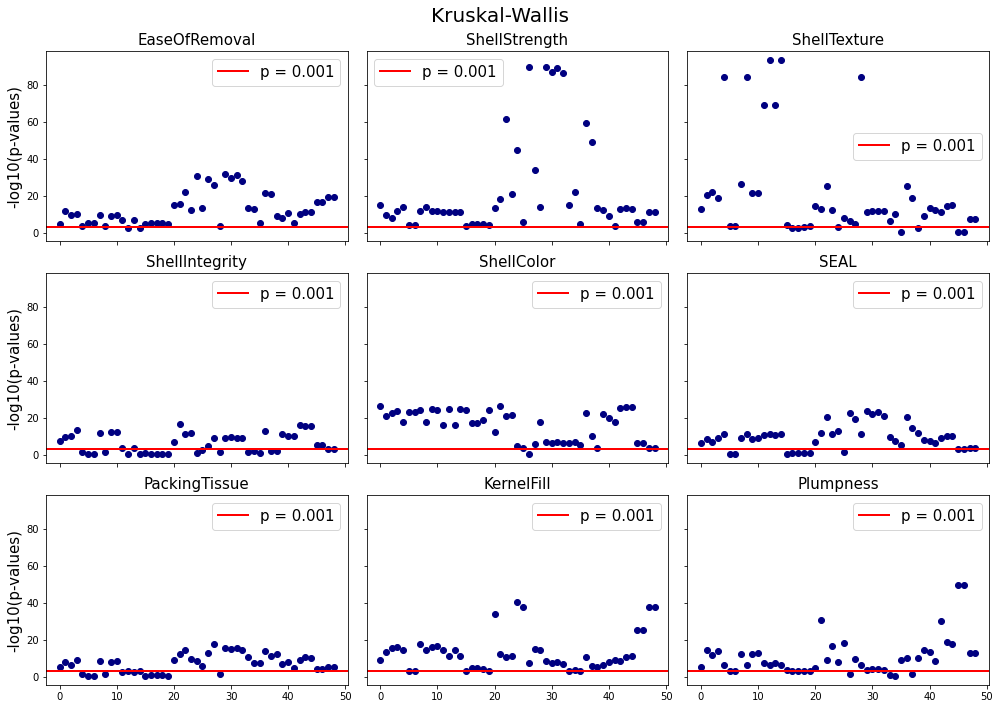

In [101]:
fig, ax = plt.subplots(3,3, figsize=(14,10), sharex=True, sharey=True)
ax = np.atleast_1d(ax).ravel()
xvals = range(len(f_oneway))
fs = 15

for i in range(len(ax)):
    ax[i].scatter(xvals, -np.log10(Kruskalp[:,i]), c='navy')
    ax[i].axhline(y=-np.log10(0.05/50), c='red', lw=2, label='p = 0.001');
    ax[i].legend(fontsize=fs)
    ax[i].set_title(cattraitnames[i], fontsize=fs)

for i in [0,3,6]:
    ax[i].set_ylabel('-log10(p-values)', fontsize=fs);

fig.suptitle('Kruskal-Wallis', fontsize=20)
plt.tight_layout()

filename = dst + 'KrukalWallis_traditional'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=100, format='jpg', pil_kwargs={'optimize':True})

In [49]:
pd.DataFrame(-np.log10(Kruskalp), columns=cattraitnames, index=df.iloc[ss].columns).T.describe().T

,count,mean,std,min,25%,50%,75%,max
nut_length,9.0,10.189123,6.965489,4.700209,5.288338,7.254170,12.792001,26.075885
nut_height,9.0,12.879149,4.881539,8.005107,9.646916,11.420001,14.435141,20.908719
nut_width,9.0,12.370877,6.252008,5.987653,7.995058,9.940780,15.336564,22.368423
nut_vol,9.0,13.833507,4.962023,8.784220,9.921163,13.078339,15.978309,23.818239
nut_va3d,9.0,17.159679,25.873262,1.441473,3.658265,11.268678,14.557641,84.312572
nut_ratio_feret,9.0,4.819166,7.067801,0.290213,0.490283,3.108025,4.307307,23.068502
nut_inv_ratio_feret,9.0,4.819166,7.067801,0.290213,0.490283,3.108025,4.307307,23.068502
nut_area,9.0,14.456082,6.729712,8.143724,9.442541,11.721787,17.703683,26.267769
nut_sphericity,9.0,17.159679,25.873262,1.441473,3.658265,11.268678,14.557641,84.312572
nut_cnvx_area,9.0,13.761800,5.801022,8.131991,9.218223,12.019830,16.191815,24.558860


In [70]:
def benjamini_hochberg(statistic, pvals, Q=1e-7):
    argpvals = np.lexsort((-statistic, pvals))
    
    bh_thr = np.arange(1,1+len(argpvals))*Q/len(argpvals)
    bh_critical = np.max(np.nonzero(pvals[argpvals] < bh_thr)[0])
    
    return bh_critical

../hpcc/traditional/results/KrukalWallis_BH_tratitional


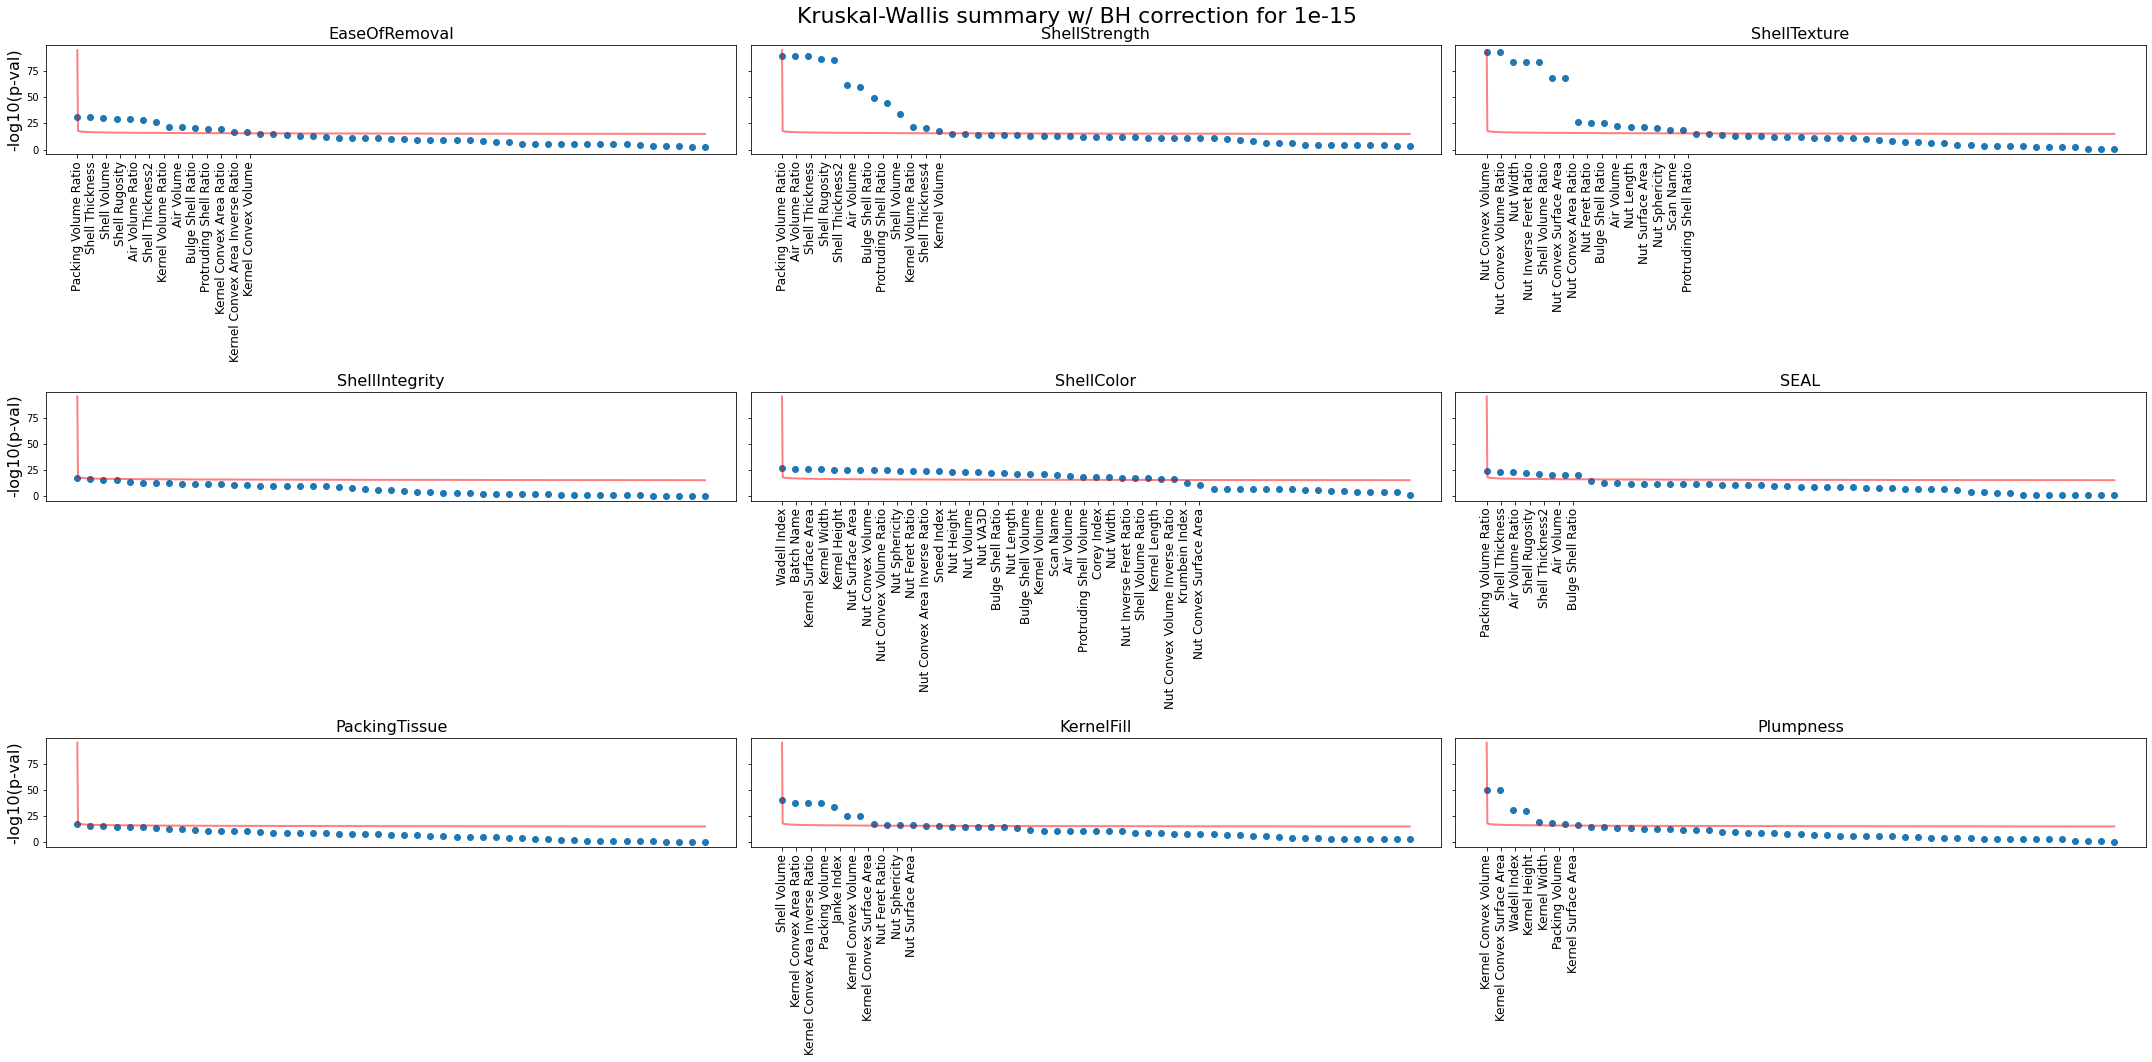

In [107]:
Q = 1e-15
fig, ax = plt.subplots(3,3,figsize=(30,15), sharey=True)
ax = np.atleast_1d(ax).ravel()
fs = 16
minval = np.min(Kruskalp)*1e15

for i in range(len(cattraitnames)):
    statistic = KruskalH[:,i]
    pvals     = Kruskalp[:,i]
    bh_critical = benjamini_hochberg(statistic, pvals, Q)
    
    argpvals = np.lexsort((-statistic, pvals))
    x = np.linspace(minval, len(argpvals)-1,1000)
    
    ax[i].set_title(cattraitnames[i], fontsize=fs)
    ax[i].plot(x, -np.log10(x*Q/len(argpvals)), lw=2, c='red', alpha=0.5)
    ax[i].scatter(np.arange(len(argpvals)), -np.log10(pvals[argpvals]))
    
    ax[i].set_xticks(np.arange(bh_critical)*1.1)
    ax[i].set_xticklabels(scol_labels[argpvals[:bh_critical]])
    ax[i].tick_params('x',labelsize=12,labelrotation=90)

for i in [0,3,6]:
    ax[i].set_ylabel('-log10(p-val)', fontsize=fs)
    #ax[i].legend(fontsize=fs-5)
    
fig.suptitle('Kruskal-Wallis summary w/ BH correction for {}'.format(Q), fontsize=22)
fig.tight_layout()

filename = dst + 'KrukalWallis_BH_tratitional'
print(filename)
plt.savefig(filename + '.jpg', bbox_inches='tight', dpi=100, format='jpg', pil_kwargs={'optimize':True})

In [97]:
scol_labels[argpvals[:bh_critical]]

array(['Kernel Convex Volume', 'Kernel Convex Surface Area',
       'Wadell Index', 'Kernel Height', 'Kernel Width', 'Packing Volume',
       'Kernel Surface Area'], dtype='<U34')

In [71]:

kbh_critical = benjamini_hochberg(KruskalH[:,0], Kruskalp[:,0], Q)
#fbh_critical = benjamini_hochberg(f_oneway, Q)
print(kbh_critical, fbh_critical, sep='\t')

13	5


../hpcc/traditional/traditional_phenotypes_merged.csv


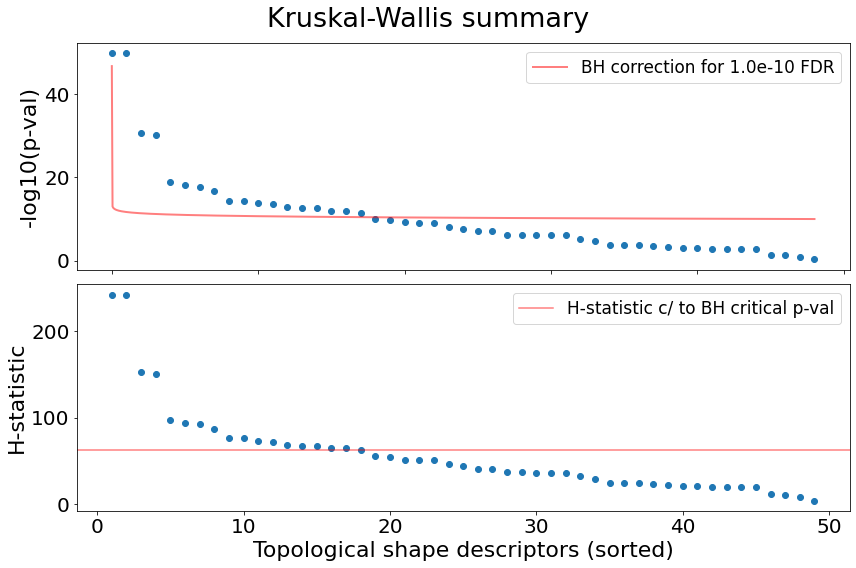

In [63]:
info_type = 'Topological'
savefig = False
dst = '../../preproc/temp/seeds/'
#filename = dst + 'kruskal_wallis_{}_{}_d{}_T{}_summary'.format(marker,'_'.join(info_type.split(' ')).lower(),d,TT)
#filename = dst + 'kruskal_wallis_{}_{}_d{}_T{}_kpca_summary'.format(marker,'_'.join(info_type.split(' ')).lower(),d,TT)
print(filename)

plot_bh_summary(kruskal, kbh_critical,
                #traits[kdirs[::-1]],
                xlab ='{} shape descriptors (sorted)'.format(info_type), 
                title = 'Kruskal-Wallis summary',
                savefig = savefig, 
                filename = filename)